<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Regression-Classification/blob/master/module1/assignment_regression_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 1

## Assignment

You'll use another **New York City** real estate dataset. 

But now you'll **predict how much it costs to rent an apartment**, instead of how much it costs to buy a condo.


The data comes from renthop.com, an apartment listing website.

- [X] Look at the data. What's the distribution of the target, `price`, and features such as `longitude` and `latitude`? Remove outliers.
- [X] After you remove outliers, what is the mean price in your subset of the data?
- [X] Choose a feature, and plot its relationship with the target.
- [X] Use scikit-learn for linear regression with one feature. You can follow the [5-step process from Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API).
- [X] Define a function to make new predictions and explain the model coefficient.
- [X] Organize and comment your code.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.

## Stretch Goals
- [X] Do linear regression with two or more features.
- [X] Read [The Discovery of Statistical Regression](https://priceonomics.com/the-discovery-of-statistical-regression/)
- [X] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 2.1: What Is Statistical Learning?
- [X] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.

# Imports

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.0.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions

# Load & Clean Data 

In [0]:
# Read New York City apartment rental listing data
raw_df = pd.read_csv('../data/renthop-nyc.csv')
assert raw_df.shape == (49352, 34)

## Data type, and Descriptive Statistics

In [0]:
# Get Pandas Profiling Report
# raw_df.profile_report()

From Pandas Profiling:

Important features to preduct our **target** (`price`) are:

## Data fields
```
    bathrooms: number of bathrooms
    bedrooms: number of bathrooms
    interest_level: the number of inquiries a new listing receives
```

And following binary features:
```
    balcony
    dogs_allowed and cats_allowed
    common_outdoor_space
    dining_room
    dishwasher
    doorman
    elevator
    exclusive
    fitness_center
    garden_patio
    hardwood_floors
    high_speed_internet
    loft
    new_construction
    no_fee
    outdoor_space
    pre-war
    roof_deck
    swimming_pool
    terrace
    wheelchair_access
```


## Cleaning Data

### Latitude vs. Longitude

### What's the distribution of the target, `price`, and features such as `longitude` and `latitude`? Remove outliers.

In [6]:
df = raw_df.drop(['description', 'created'], axis=1)
df.head()

bathrooms  bedrooms  ... wheelchair_access  common_outdoor_space
0        1.5         3  ...                 0                     0
1        1.0         2  ...                 0                     0
2        1.0         1  ...                 0                     0
3        1.0         1  ...                 0                     0
4        1.0         4  ...                 0                     0

[5 rows x 32 columns]

### `price`

From pandas profiling report we know the price is highly skewed, let's look at records whose price is greater than $1 million.

In [7]:
df.query('price > 100000')['price'].value_counts()

1070000    2
111111     1
4490000    1
135000     1
1150000    1
Name: price, dtype: int64

In [8]:
df.query('price > 100000')

bathrooms  bedrooms  ... wheelchair_access  common_outdoor_space
9590         1.0         2  ...                 0                     0
10581        0.0         0  ...                 0                     0
19558        1.0         2  ...                 0                     0
25538        1.0         0  ...                 0                     0
29665        1.0         1  ...                 0                     0
30689        1.0         1  ...                 0                     0

[6 rows x 32 columns]

Let's see if they fall above 95% percentile,

In [9]:
df['price'].quantile(q=[0.01, 0.5, 0.99])

0.01     1475.0
0.50     3150.0
0.99    13000.0
Name: price, dtype: float64

In [10]:
df = df[(df['price'] >= df['price'].quantile(q=0.01)) & (df['price'] <= df['price'].quantile(q=0.99))]
df['price'].describe()

count    48379.000000
mean      3538.636888
std       1597.663167
min       1475.000000
25%       2500.000000
50%       3150.000000
75%       4065.000000
max      13000.000000
Name: price, dtype: float64

### `latitude vs. longitude`

In [11]:
# Scatter plot will help us visualize the outliers better
px.scatter(df, 'latitude', 'longitude', hover_data=['street_address', 'price'], title='Latitude vs. Longitude')

From scatter plots, we can see extreme value, let's investigate  locations which are `0, 0` and `-118, 34`. Let's figure out the 1% and 99% quantiles, and look at the those values that are outside that range.

In [12]:
def get_quantiles(df, cols):
    return df[cols].quantile(q=[.01, .25, .5, .75, .95, .99])

def get_leq_quantile(df, col, q):
    return df[(df[col] <= df[col].quantile(q=q))]

def get_geq_quantile(df, col, q):
    return df[(df[col] >= df[col].quantile(q=q))]

def get_between_quantiles(df, col, qs):
    lower_q = min(qs)
    upper_q = max(qs)
    return df[(df[col] >= df[col].quantile(q=lower_q)) & (df[col] <= df[col].quantile(q=upper_q))]

# We can see most latitude values fall between 1% and 99% quantiles
get_quantiles(df, ['latitude', 'longitude'])

latitude  longitude
0.01  40.643956   -74.0162
0.25  40.728200   -73.9918
0.50  40.751600   -73.9781
0.75  40.773900   -73.9552
0.95  40.815200   -73.9285
0.99  40.855822   -73.8570

Most of our apartment rental listings lie within latitudes 40.6 - 40.8, and longitudes -74.01 and -73.85, which tells us any coordinates outside could be considered outliers and may not be in NYC (New York City), especially like the ones we spotted in the scatter plot above.

In [13]:
df[(df['latitude'] == 0) & (df['longitude'] == 0)]

bathrooms  bedrooms  ... wheelchair_access  common_outdoor_space
2787         5.0         6  ...                 0                     0
14104        1.0         1  ...                 0                     0
21715        1.0         1  ...                 0                     0
22471        1.0         2  ...                 0                     0
25860        1.0         2  ...                 0                     0
27181        1.0         2  ...                 0                     0
34390        1.0         1  ...                 0                     0
35826        1.0         2  ...                 0                     0
36448        1.0         1  ...                 0                     0
39199        1.0         2  ...                 0                     0
42987        1.0         0  ...                 0                     0

[11 rows x 32 columns]

It would hard to say without latitude and longitudes where the location for the apartments is, and `street_address` without zipcode also gives us very little location information. Now, let's look at the coordinates at that are less than `(-80, 40)`.

In [14]:
df[(df['longitude'] <= -80) & (df['latitude'] <= 40)]

bathrooms  bedrooms  ... wheelchair_access  common_outdoor_space
2150         1.0         0  ...                 0                     0
22767        1.0         1  ...                 0                     0

[2 rows x 32 columns]

Again, the address doesn't give us any valuable information to reverse locate the geo-location without proper zipcode.

Let's remove the outliers that are below the 1% and 99% quantile range.

In [15]:
df = get_between_quantiles(df, 'latitude', [.01, .99])
df = get_between_quantiles(df, 'longitude', [.01, .99])
df[['latitude', 'longitude']].describe()

latitude     longitude
count  46463.000000  46463.000000
mean      40.751426    -73.974501
std        0.034466      0.023563
min       40.644000    -74.015600
25%       40.729800    -73.991600
50%       40.752800    -73.978400
75%       40.773600    -73.956400
max       40.855800    -73.859100

Now the `min` and `max` are within NYC, not outside it.

In [16]:
# Let's quickly verify again with a scatter plot to see if the outliers are removed, and get proper distribution of values
px.scatter(df, 'latitude', 'longitude', hover_data=['street_address', 'price'], title='Latitude vs. Longitude', marginal_x="histogram", marginal_y="histogram")

## Drop `street_address`, and `display_adderss`

In [17]:
# Since we latitude and longitude features, we don't need addresses.
# Also, addresses are incomplete with no proper zip to verify them.
df = df.drop(['display_address', 'street_address'], axis=1)
df.head()

bathrooms  bedrooms  ...  wheelchair_access  common_outdoor_space
0        1.5         3  ...                  0                     0
1        1.0         2  ...                  0                     0
2        1.0         1  ...                  0                     0
3        1.0         1  ...                  0                     0
4        1.0         4  ...                  0                     0

[5 rows x 30 columns]

### `bedroom vs bathroom`

`bedrooms`: Looking at above quantile result, 95% of the bedrooms are within 0 and 3, while 99% of percentile covers upto 4 bedrooms, any thing above that will have to be considered as outlier

`bathrooms`: While for bathrooms its between 1 and 3, anything below or above would be an outlier.

The anomaly here is extreme values seen in pandas profiling report.

In [18]:
get_quantiles(df, ['bedrooms', 'bathrooms'])

bedrooms  bathrooms
0.01       0.0        1.0
0.25       1.0        1.0
0.50       1.0        1.0
0.75       2.0        1.0
0.95       3.0        2.0
0.99       4.0        3.0

In [19]:
# Let's once again look at the min and max values,
df[['bedrooms', 'bathrooms']].describe()

bedrooms     bathrooms
count  46463.000000  46463.000000
mean       1.536104      1.198222
std        1.108306      0.458993
min        0.000000      0.000000
25%        1.000000      1.000000
50%        1.000000      1.000000
75%        2.000000      1.000000
max        8.000000     10.000000

Both have `min` of 0 bedroom and bathroom, while `max` bedrooms are 8 and bathrooms are 10, let's look at the heatmap.

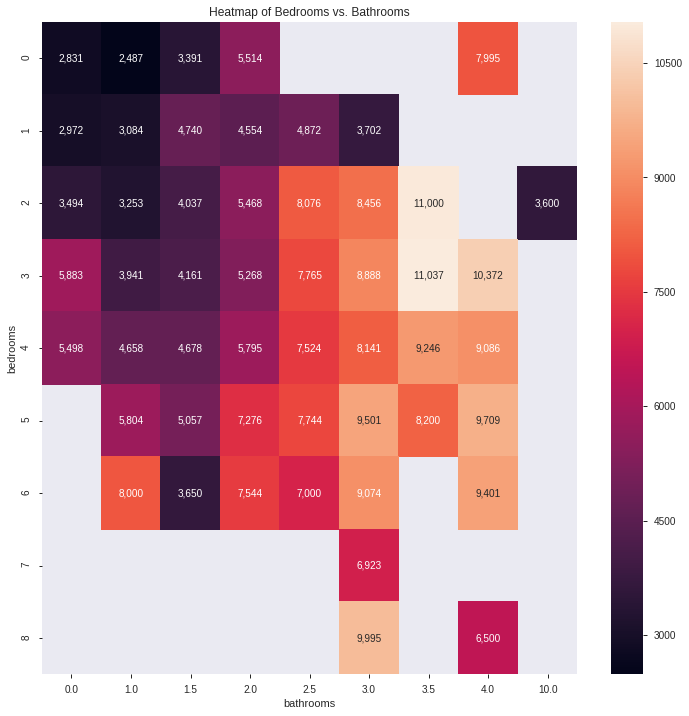

In [20]:
# Plotting heatmap will help us visualize the outliers, and find anomalies in the dataset
table = df.pivot_table('price', 'bedrooms', 'bathrooms')
plt.figure(figsize=(12,12))
ax = sns.heatmap(table, annot=True, fmt=',.0f', cbar=True)
ax.set_title('Heatmap of Bedrooms vs. Bathrooms');

There are lot of anomalies here, normally we would expect the `bedrooms` to `bathrooms` to be higher ratio, or at least equal, and if it is studio, than no bedrooms but a single or half bathroom at least, but based on above heat map looks like dataset has anomalies like:

- `0 bedrooms, 0 bathrooms` with higher price than those with `0 bedrooms, 1 bathrooms`

- `2 bedrooms, 10 bathrooms` has way to many bathrooms, could be a typo, or data entry mistake as price is cheaper than `3 bed, 3.5 bath` apartment.

In short any `bedrooms` and `bathrooms` that fall below 1% and above 99% quartiles will be an outlier, so let's filter them out.

In [21]:
df = get_between_quantiles(df, 'bedrooms', [.01, .99])
df = get_between_quantiles(df, 'bathrooms', [.01, .99])
df[['bedrooms', 'bathrooms']].describe()

bedrooms     bathrooms
count  45848.000000  45848.000000
mean       1.516969      1.194371
std        1.073791      0.423200
min        0.000000      1.000000
25%        1.000000      1.000000
50%        1.000000      1.000000
75%        2.000000      1.000000
max        4.000000      3.000000

Now we have succesfully removed the anomalies and outliers, let's view the heatmap again.

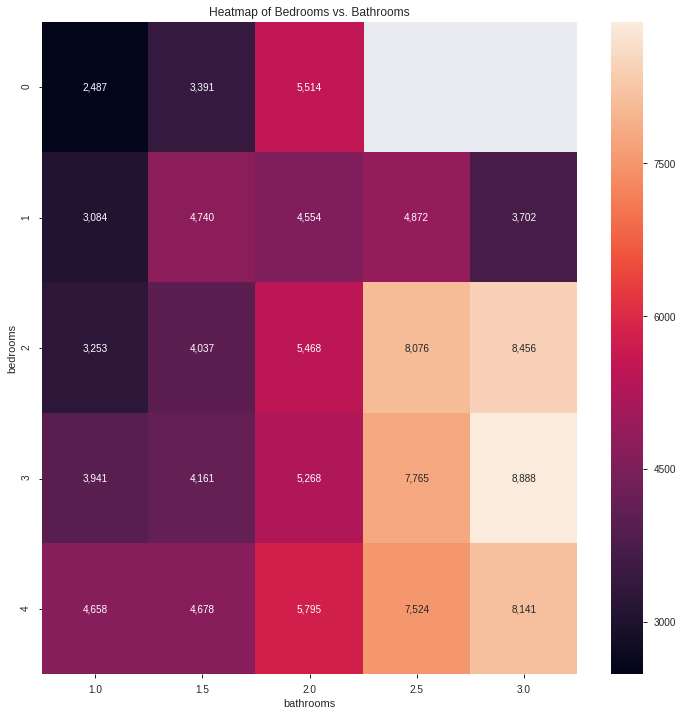

In [22]:
# Plotting heatmap will help us visualize the outliers, and find anomalies in the dataset
table = df.pivot_table('price', 'bedrooms', 'bathrooms')
plt.figure(figsize=(12,12))
ax = sns.heatmap(table, annot=True, fmt=',.0f', cbar=True)
ax.set_title('Heatmap of Bedrooms vs. Bathrooms');

Now the `prices` make sense, as we go diagonally to towards top-left the price gets cheaper, while towards bottom-right price gets higher towards costlier rentals.

## Missing vals

In [23]:
# We know based on pandas profiling there were no missing values, 
# let's verify it again
df.isnull().sum() # Checks for total missing value counts for each features

bathrooms               0
bedrooms                0
latitude                0
longitude               0
price                   0
interest_level          0
elevator                0
cats_allowed            0
hardwood_floors         0
dogs_allowed            0
doorman                 0
dishwasher              0
no_fee                  0
laundry_in_building     0
fitness_center          0
pre-war                 0
laundry_in_unit         0
roof_deck               0
outdoor_space           0
dining_room             0
high_speed_internet     0
balcony                 0
swimming_pool           0
new_construction        0
terrace                 0
exclusive               0
loft                    0
garden_patio            0
wheelchair_access       0
common_outdoor_space    0
dtype: int64

In [24]:
df.shape

(45848, 30)

From 50K we now have around 45K of data left, it looks like we lost around 4K from removing outliers.

## Feature Engineering

### Combine `dogs_allowed` and `cats_allowed` into `pets_allowed` since they are redundant features with high correlation.

In [25]:
# Combine them into a new feature pets_allowed
df['pets_allowed'] = (df['dogs_allowed'] & df['cats_allowed'])
# Drop cats and dogs allowed
df = df.drop(['dogs_allowed', 'cats_allowed'], axis=1)
df['pets_allowed'].value_counts()

0    25311
1    20537
Name: pets_allowed, dtype: int64

In [26]:
# Let's verify the columns were dropped and new feature was added
df.head()

bathrooms  bedrooms  ...  common_outdoor_space  pets_allowed
0        1.5         3  ...                     0             0
1        1.0         2  ...                     0             1
2        1.0         1  ...                     0             0
3        1.0         1  ...                     0             0
4        1.0         4  ...                     0             0

[5 rows x 29 columns]

### Label encode categorical `interest_level` data type

In [27]:
# Let's look at the counts first before we encode it
df['interest_level'].value_counts()

low       32028
medium    10567
high       3253
Name: interest_level, dtype: int64

In [28]:
# Now the counts match, we are ready to encode
df['interest_level'].map({'low':1, 'medium':2, 'high':3}).value_counts()

1    32028
2    10567
3     3253
Name: interest_level, dtype: int64

In [29]:
# Label encode
df['interest_level'] = df['interest_level'].map({'low':1, 'medium':2, 'high':3})
df.info() # Verify the data type is correct

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45848 entries, 0 to 49350
Data columns (total 29 columns):
bathrooms               45848 non-null float64
bedrooms                45848 non-null int64
latitude                45848 non-null float64
longitude               45848 non-null float64
price                   45848 non-null int64
interest_level          45848 non-null int64
elevator                45848 non-null int64
hardwood_floors         45848 non-null int64
doorman                 45848 non-null int64
dishwasher              45848 non-null int64
no_fee                  45848 non-null int64
laundry_in_building     45848 non-null int64
fitness_center          45848 non-null int64
pre-war                 45848 non-null int64
laundry_in_unit         45848 non-null int64
roof_deck               45848 non-null int64
outdoor_space           45848 non-null int64
dining_room             45848 non-null int64
high_speed_internet     45848 non-null int64
balcony                 45848 

### `total_rooms`

In [30]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['total_rooms'].value_counts()

2.0    14398
3.0    10517
1.0     8765
4.0     6647
5.0     3088
6.0     1493
4.5      275
3.5      205
5.5      156
2.5      147
7.0      111
6.5       37
1.5        9
Name: total_rooms, dtype: int64

Now we have final dataframe with all the filtered out anomalies, next let's look at correlation heatmap to identify important features. 

## Correlations

In [31]:
def correlations(data, y, xs):
    from scipy import stats
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

correlations(df, 'price', df.columns.tolist())

feature         r       rho
0              bathrooms  0.678914  0.555131
1               bedrooms  0.537039  0.579334
2               latitude -0.070656 -0.141951
3              longitude -0.270592 -0.339427
4                  price  1.000000  1.000000
5         interest_level -0.188339 -0.207891
6               elevator  0.221828  0.266639
7        hardwood_floors  0.084234  0.105779
8                doorman  0.287919  0.332501
9             dishwasher  0.217928  0.266875
10                no_fee  0.125844  0.168466
11   laundry_in_building -0.019763 -0.006780
12        fitness_center  0.243657  0.287053
13               pre-war -0.030481 -0.036161
14       laundry_in_unit  0.252254  0.248978
15             roof_deck  0.124485  0.159899
16         outdoor_space  0.133682  0.158743
17           dining_room  0.223960  0.202809
18   high_speed_internet  0.096989  0.113628
19               balcony  0.125308  0.140317
20         swimming_pool  0.133421  0.129023
21      new_construction  0.067172  0.072177
22               terrace  0.127979  0.129976
23             exclusive -0.001287 -0.017084
24                  loft -0.023321 -0.066126
25          garden_patio  0.089473  0.095554
26     wheelchair_access  0.073656  0.069724
27  common_outdoor_space  0.013391  0.035574
28          pets_allowed  0.068493  0.087235
29           total_rooms  0.646013  0.631125

It looks like `bathrooms` and `bedrooms` are the most important features, amenities are not actually that important in predicting the `price`.

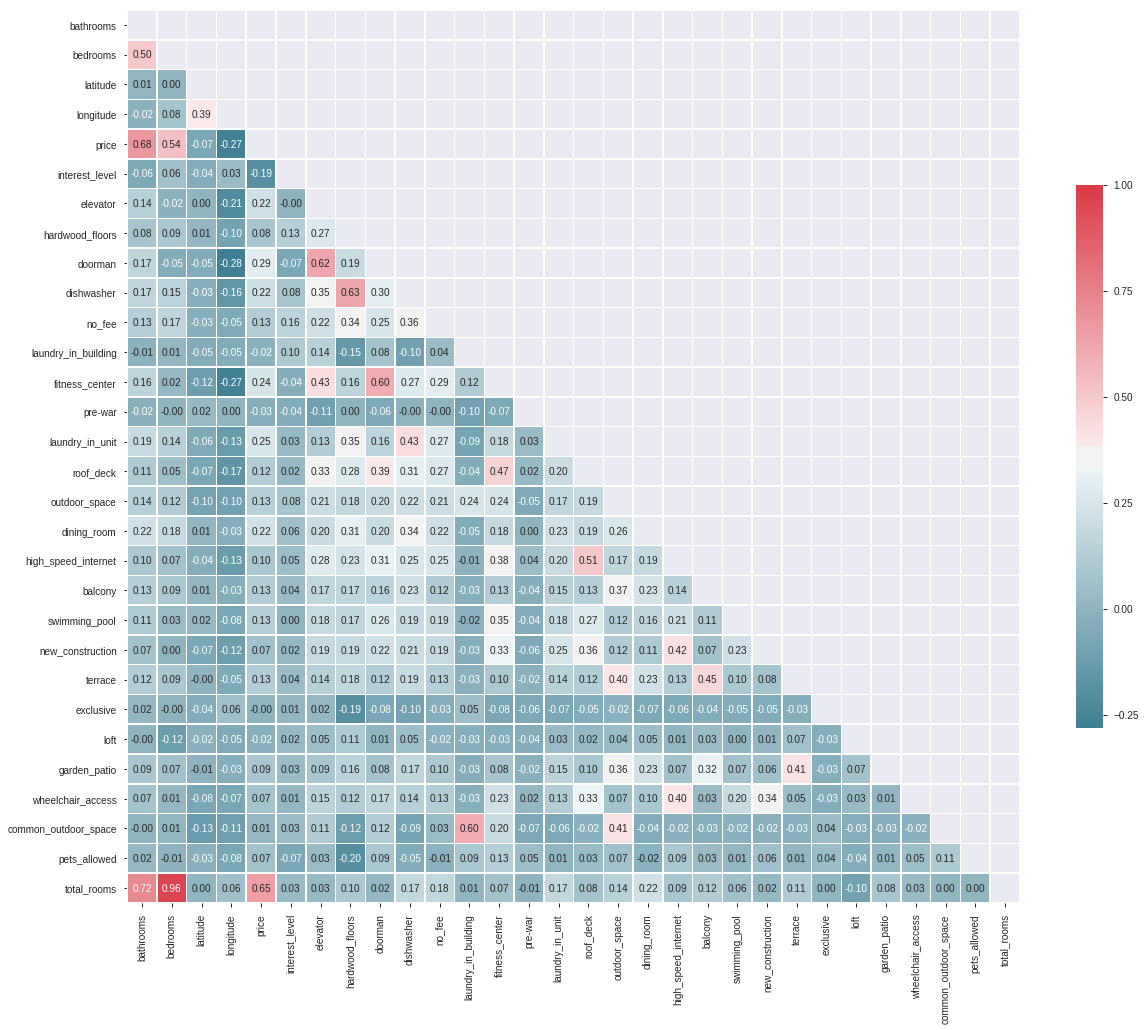

In [32]:
def correlation_heatmap(data=None, vmax=1, annot=True, corr_type='pearson'):
    if data is None:
        raise ValueError(
            "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    # Taken from the seaborn example at:
    # http://seaborn.pydata.org/examples/many_pairwise_correlations.html
    # Compute the correlation matrix
    corr = data.corr(corr_type)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    fig, axes = plt.subplots(figsize=(20, 20))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=vmax, annot=annot, square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, fmt=',.2f', ax=axes)
    plt.show()
    plt.close()

correlation_heatmap(df)

## Rental listing maps plotted with price as marker size indicator

In [33]:
mapbox_token = 'pk.eyJ1IjoiaHVuZ3J5cGllMDAiLCJhIjoiY2p5bnIydW1iMHd1cDNjbG12OHBnMDVycSJ9.dRMQF8kTJQ7yqIWlTGl4oQ'
px.set_mapbox_access_token(mapbox_token)
px.scatter_mapbox(df, lat='latitude', lon='longitude', color='price', zoom=11, size='price', hover_data=['bedrooms', 'bathrooms'])

# Linear Regression Model

In [0]:
def linear_model_results(data, features, target, seed=12345):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    results = {}
    results['n'] = data.shape

    # Import to split the data into training/testing sets
    from sklearn.model_selection import train_test_split
    # Import Linear Model
    from sklearn.linear_model import LinearRegression
    # Import metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # Extract features 
    X = df[features]
    y = df[target]
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
    # Instantiate Linear Regression Mode
    model = LinearRegression().fit(X_train, y_train)
    # Add model to results
    results['model'] = model
    # Add coefficients to results
    results['coefficients'] = model.coef_[0]
    # Add R^2 
    results['r_squared'] = model.score(X_test, y_test)
    # Add Residuals
    y_hat = model.predict(X_test)
    results['residual'] = y_test - y_hat
    # MSE
    results['MSE'] = sum(results['residual']**2) / len(results['residual'])
    # MAE
    results['MAE'] = mean_absolute_error(y_test, y_hat)
    return results


## Baseline Model

Let's look at the baseline mode first...

In [35]:
df['price'].describe()

count    45848.000000
mean      3553.884619
std       1538.439928
min       1475.000000
25%       2500.000000
50%       3195.000000
75%       4100.000000
max      13000.000000
Name: price, dtype: float64

Avg. prediction for apartment rent is around $3550 in NYC.

## Model based on important feature - `total_rooms`, `bedrooms`, and `bathrooms`

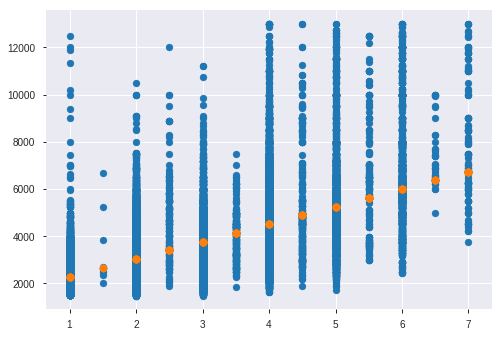

In [36]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

# 2. Instantiate the linear model
model = LinearRegression()

# 3. Select features
features = ['total_rooms']
target = 'price'
X = df[features]
y = df[target]

# 4. Fit the mode
model.fit(X, y)

# 5. Apply the model
y_pred = model.predict(X)

# 6. Plot Actual vs. Predicted
plt.scatter(X, y)
plt.scatter(X, y_pred);

#### Equation for the line

In [37]:
# Equations for a line
print('y = mx + b')
print(f'y = {model.coef_[0]}*x + {model.intercept_}')
print(f'price = {model.coef_[0]}*total_rooms + {model.intercept_}')

y = mx + b
y = 743.1170224014998*x + 1539.0419757411614
price = 743.1170224014998*total_rooms + 1539.0419757411614


In [38]:
# 7. Apply the model to *new/unknown* data
def predict(square_feet):
    y_pred = model.predict([[square_feet]])
    return y_pred[0]

predict(3)

3768.393042945661

In [39]:
# 8. Give nicer output
def predict(feature):
    y_pred = model.predict([[feature]])
    estimate = y_pred[0]
    coefficient = model.coef_[0]
    
    # Format with $ and comma separators. No decimals.
    result = f'${estimate:,.0f} estimated rental price for {feature:,.0f} total room apartment in NYC.'
    explanation = f' Each additional room is associated with a ${coefficient:,.0f} increase in this model.'
    return result + explanation

predict(1)

'$2,282 estimated rental price for 1 total room apartment in NYC. Each additional room is associated with a $743 increase in this model.'

> NOTE: Currently we can't tell how is our model doing let's split the dataset into train-test and compute it's $R^2$ metric to see how it is doing.

## Model with 2 or more features

In [40]:
# 1. Extract features and target
target = 'price'
omit_features = []
omit_features.append(target)
features = [col for col in df.columns.tolist() if col not in omit_features]

# 2. Apply linear model and store results dict
results = linear_model_results(df, features, target)

# 3. Pretty Print the results out
print("""
----------- Linear Regression Model Results -------------
R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
MSE: {:.2f}
MAE: {:.2f}
""".format(results['r_squared'], results['MSE'], results['MAE']))


----------- Linear Regression Model Results -------------
R^2: 0.66 (Explained variance score: 1 is perfect prediction)
MSE: 810327.39
MAE: 608.80

